#This Project is developed to take a wav file of a single voice of music and get the musical pitch at any time frame.

Imports:

In [259]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import statistics
import random
import math
import librosa
import json

Name of User (used in application)

In [260]:
userId = 'user'

Load audio file (only accepts .wav file)

In [261]:
fileName = "2025-05-29T03_07_03.892Z.wav"
originalFileLoc = "./data/raw/" + fileName
x, sr = librosa.load(originalFileLoc)
audioDuration = librosa.get_duration(y=x, sr=sr)

Set values

In [262]:
defaultDecimalRate = 5
defaultLoweringRate = 3
defaultDurationTime = 0.05
defaultMinDist = defaultDurationTime

pitchToLetter = {
    0: 'C',
    1: 'C#',
    2: 'D',
    3: 'D#',
    4: 'E',
    5: 'F',
    6: 'F#',
    7: 'G',
    8: 'G#',
    9: 'A',
    10: 'A#',
    11: 'B'
}

pitches = {0: 65.406}
currentPitch = 0
while currentPitch <= 71:
    prevPitch = pitches[currentPitch]
    currentPitch += 1            
    pitches[currentPitch] = prevPitch * (2 ** (1/12))

Get notes from freq

In [263]:
def freqToNotes(freqList):
    retFreqList = []
    for x in freqList:
        if (x >= 65.406):
            retFreqList.append((12 * math.log((500 * x) / 32523)) / (math.log(2)))
        else: 
            retFreqList.append(-1)
    return retFreqList

Create Functions

In [264]:
def is_close(a, b, tolerance=1e-2):
       return abs(a - b) < tolerance

def lowerRate(lst, rte, decimalRate):
    """(List of signal, updated rate (x))
    Used to lower bitrate by a factor of x to fix fuzz"""
    retList = []
    for i in range(int(len(lst) / rte) - 1):
        includedIndices = [lst[i * rte]]
        for j in range(rte):
            includedIndices.append(lst[(i * rte) + j + 1])
        retList.append(round(statistics.median(includedIndices),decimalRate))
    return (retList)

Pitch Analyzer Class:

In [265]:
class PitchAnalyzer:
    def __init__(self, filename, decimalRate = defaultDecimalRate, loweringRate = defaultLoweringRate, minDist = defaultMinDist, durationTime = defaultDurationTime):
        self.decimalRate = decimalRate
        self.loweringRate = loweringRate
        self.minDist = minDist
        self.durationTime = durationTime
        
        spf = wave.open(filename, "r")
        signal = spf.readframes(-1)
        signal = np.frombuffer(signal, np.int16)
        
        frameRate = spf.getframerate()
        
        timeList = []
        
        newDuration = (len(signal) / frameRate)
        if is_close(newDuration / 2, audioDuration): 
            for i in range(len(signal)):
                timeList.append(round((i / 2) / frameRate,self.decimalRate))
                
        else:
            for i in range(len(signal)):
                timeList.append(round(i / frameRate,self.decimalRate))
                

        
        
        
            
        if self.loweringRate != 1:
            signal = lowerRate(signal, self.loweringRate, self.decimalRate)
            timeList = lowerRate(timeList, self.loweringRate, self.decimalRate)
            
            
        self.signal = signal.copy()
        self.timeList = timeList.copy()
        self.length = timeList[-1]
        
    def createWavGraph(self, fileLoc):
        
        plt.figure(1)
        plt.title("Musical Plot of: " + fileLoc)
        plt.plot(self.timeList, self.signal)
        
        # for i in (changesOfDerivative):
        #     plt.plot(timeList[i], signal[i], 'ro')
        #     plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        # for i in (antiPeaks):
        #     plt.plot(timeList[i], signal[i], 'bo')
        
        plt.savefig(fileLoc)
        plt.show()
        plt.close()

        # plt.savefig('my_plot.png')
    
    def graphPitches(self, fileLoc):
        retFreqList = []
        retTimeList = []
        i = 0
        
        while i < self.length - 0.1:
            try:
                retFreqList.append(self.getPitchAtTime(i))
                retTimeList.append(i)
            except Exception as err:
                print(err)
                pass

            i += self.durationTime
            
        specTimeLoc = retTimeList[random.randint(0,len(retTimeList) - 1)]
        
        self.getPitchAtTime(specTimeLoc, fileName = ("./data/processed/plotPartial" + userId + ".png"))
        self.createWavGraph(fileLoc = ("./data/processed/plotFull" + userId + ".png"))
        
            
        avgVal = statistics.median(retFreqList)
        removeIndexes = []
        for i in range(len(retFreqList)):
            currentVal = retFreqList[i]
            if not (currentVal) < (avgVal * (1 + (self.minDist * 10))) and (currentVal) > (avgVal * (1 - (self.minDist * 0.1))):
                removeIndexes.append(i)
                
        retFreqList = [item for index, item in enumerate(retFreqList) if index not in removeIndexes]
        retTimeList = [item for index, item in enumerate(retTimeList) if index not in removeIndexes]

        retFreqList = freqToNotes(retFreqList)
        
        retFreqList = lowerRate(retFreqList, 5, self.decimalRate)
        retTimeList = lowerRate(retTimeList, 5, self.decimalRate)

        timeFreqDict = {}
        for i in range(len(retTimeList)):
            currentPitchClass = retFreqList[i]
            currentNoteName = round(currentPitchClass, 0)
            currentNoteInaccuracy = currentPitchClass - currentNoteName
            currentNoteName %= 12
            currentNoteName = pitchToLetter[currentNoteName]
            timeFreqDict[retTimeList[i]] = currentNoteName
        
        with open("./data/processed/timeFreq.json", "w") as outfile:
            json.dump(timeFreqDict, outfile)

            
        plt.figure(1)
        plt.title("Frequency (hz) over time (seconds)" )
        plt.plot(retTimeList, retFreqList)
        
        # for i in (changesOfDerivative):
        #     plt.plot(timeList[i], signal[i], 'ro')
        #     plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
        # for i in (antiPeaks):
        #     plt.plot(timeList[i], signal[i], 'bo')
        
        plt.savefig(fileLoc)
        plt.show()
        plt.close()
            
        
        
        
         


    def getPitchAtTime(self, startTime, fileName = False, durationTime = False):
        """(Start time in seconds, End time in seconds, name of .wav file)
        Returns most common frequency at the listed time"""
        
        if (durationTime == False):
            durationTime = self.durationTime
        
        decimalRate = self.decimalRate
        minDist = self.minDist
        
        startTime = round(startTime, decimalRate)
        durationTime = round(durationTime, decimalRate)
        
        signal = self.signal.copy()
        timeList = self.timeList.copy()
        
        signalAvg = np.max(signal) + np.min(signal)
        signal = signal - signalAvg
        

        while(startTime not in timeList):
            startTime = round(startTime + 1 / 10 ** decimalRate,decimalRate)
        startIndex = int(timeList.index(startTime))
        while (startTime + durationTime not in timeList):
            durationTime += 1 / 10 ** decimalRate
            durationTime = round(durationTime, decimalRate)
        endIndex = int(timeList.index(startTime + durationTime))


        
        signal = signal[startIndex:endIndex]
        timeList = timeList[startIndex:endIndex]

        peakVals = [signal[0]]
        peakTimes = [timeList[0]]
        for index, i in enumerate(signal):
            j = timeList[index]
            if (abs(i) > abs(peakVals[-1]) and i * peakVals[-1] >= 0):
                peakVals[-1] = i
                peakTimes[-1] = j
            elif (peakVals[-1] * i < 0):
                peakVals.append(i)
                peakTimes.append(j)
                
        ### Remove non global max / mins
        peakValsA = peakVals[::2]
        peakTimesA = peakTimes[::2]
        
        topValA = max(peakValsA, key=abs)
        indexToRemoveA = []
        for i in range(len(peakValsA)):
            if (abs(peakValsA[i]) / abs(topValA)) < 0.85:
                indexToRemoveA.append(i)
                
        for i in sorted(indexToRemoveA, reverse=True):
            del peakValsA[i]
            del peakTimesA[i]
                
        
        peakValsB = peakVals[1::2]
        peakTimesB = peakTimes[1::2]
        
        topValB = max(peakValsB, key=abs)
        indexToRemoveB = []
        for i in range(len(peakValsB)):
            if (abs(peakValsB[i]) / abs(topValB)) < 0.85:
                indexToRemoveB.append(i)
                
        for i in sorted(indexToRemoveB, reverse=True):
            del peakValsB[i]
            del peakTimesB[i]
            
        peakVals = peakValsA + peakValsB
        peakTimes = peakTimesA + peakTimesB
            

        graphVals = []
        for i in range(len(peakVals)):
            graphVals.append([peakVals[i], peakTimes[i]])

        
        signalDerivative = []

        for i in range(len(signal) - 1):
            topNum = signal[i + 1]
            botNum = signal[i]
            signalDerivative.append(topNum - botNum)
            
        prevVal = signalDerivative[0]
        changesOfDerivative = []
        antiPeaks = []
        for i in range(len(signalDerivative) - 1):
            currentVal = signalDerivative[i + 1]
            
            if currentVal * prevVal < 0:
                changesOfDerivative.append(i + 1)

        frequencies = []
        
        for i in range(len(peakTimes) - 1):
            topNum = peakTimes[i + 1]
            botNum = peakTimes[i]
            if topNum != botNum:
                frequencies.append((1/(topNum - botNum)))
            
        avgFreq = statistics.median(frequencies)
        
        if (fileName != False):
        
            plt.figure(1)
            plt.title("Musical Plot of: " + fileName)
            plt.plot(timeList, signal)
            for i in (changesOfDerivative):
                plt.plot(timeList[i], signal[i], 'ro')
                plt.annotate(f'({round(timeList[i],4)})', (timeList[i], signal[i]), textcoords="offset points", xytext=(0, 10), ha='center')
            for i in (graphVals):
                plt.plot(i[1], i[0], 'bo')

            plt.savefig(fileName) 
            plt.show()
            plt.close()
        
        return(avgFreq)

Create analyzer

In [266]:
thisAnalyzer = PitchAnalyzer(originalFileLoc)

/Users/dominicsitto/.pyenv/versions/3.10.17/lib/python3.10/statistics.py:457: RuntimeWarning: overflow encountered in scalar add
  return (data[i - 1] + data[i]) / 2


Graph all pitches

max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence


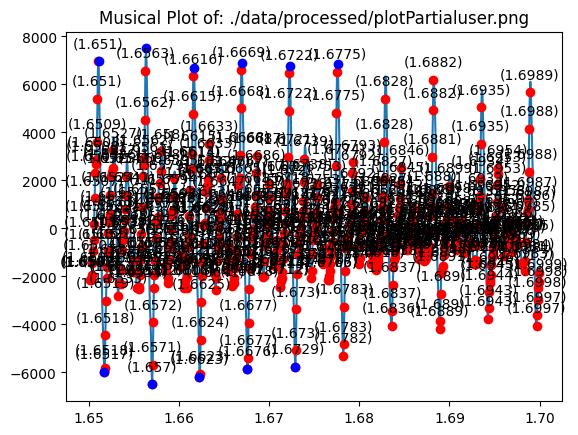

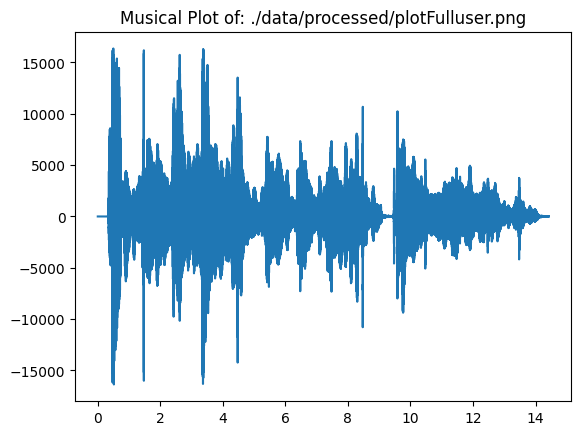

KeyError: 4.399999999999999

In [267]:
thisAnalyzer.graphPitches("./data/processed/pitchesPlotFull" + userId + ".png")